In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# FERMI DATA

In [2]:
from DynGenModels.models.resnet import ResNet
from DynGenModels.models.resnet_config import ResNetConfig as Config

config = Config(dataset = 'fermi_data_galactic_coord.npy',
                features    = ['theta', 'phi', 'energy'],
                preprocess  = ['normalize', 'logit_transform', 'standardize'],
                cuts = {
                        'theta': [-10., 10.], 
                        'phi': [4., 10.], 
                        'energy': [1000, 2000]
                        },
                data_split_fracs = [0.7, 0.2, 0.1],
                epochs = 2000,
                early_stopping=100,
                batch_size = 256,
                warmup_epochs = 50,
                lr = 1e-4,
                dim_hidden = 512, 
                num_layers = 10,
                device = 'cpu',
                solver='euler',
                num_sampling_steps=100,
                seed = 9999
                )

root_dir =  '/home/df630/' if 'cuda' in config.device else '/Users/dario/Dropbox/PROJECTS/ML/'
root_dir += 'DynGenModels'
config.set_workdir(root_dir + '/results', save_config=True)

resnet = ResNet(config)


#===============================================================================================================================
INFO: created directory: /Users/dario/Dropbox/PROJECTS/ML/DynGenModels/results/ResNet.fermi_galactic_center_2023.09.24_20h44__1
#===============================================================================================================================
+--------------------+-------------------------------------------------+
| Key                | Value                                           |
+--------------------+-------------------------------------------------+
| dataset            | fermi_data_galactic_coord.npy                   |
| data_name          | fermi_galactic_center                           |
| features           | ['theta', 'phi', 'energy']                      |
| preprocess         | ['normalize', 'logit_transform', 'standardize'] |
| cuts               | theta: [-10.0, 10.0]                            |
|                    | phi: [4

In [3]:
from DynGenModels.datamodules.fermi.datasets import FermiDataset
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader

datasets = FermiDataset(dir_path = root_dir + '/data/fermi', 
                        dataset = config.dataset,
                        cuts = config.cuts,
                        preprocess = config.preprocess,
                        ) 
dataloader = FermiDataLoader(datasets, data_split_fracs=config.data_split_fracs, batch_size=config.batch_size)


INFO: loading and preprocessing data...
	- dataset: /Users/dario/Dropbox/PROJECTS/ML/DynGenModels/data/fermi 
 	- shape: torch.Size([162173, 3])
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.7/0.2/0.1
INFO: train size: 113521, validation size: 32434, testing sizes: 16218


In [4]:
from DynGenModels.trainer.trainer import FlowMatchTrainer
from DynGenModels.dynamics.flowmatch import SimplifiedCondFlowMatching

dynamics = SimplifiedCondFlowMatching(resnet)

CFM = FlowMatchTrainer(dynamics=dynamics, 
                       dataloader=dataloader,
                       workdir=config.workdir,
                       lr=config.lr,
                       epochs=config.epochs,
                       early_stopping=config.early_stopping,
                       warmup_epochs=config.warmup_epochs)

CFM.train()

INFO: number of training parameters: 595843


epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

	 test loss: 0.006547018908584001  (min loss: 0.006547018908584001)
	 test loss: 0.0066054249953612035  (min loss: 0.006247875582696242)
	 test loss: 0.00611070395545115  (min loss: 0.00611070395545115)
	 test loss: 0.006250312566213237  (min loss: 0.006079631076829681)


In [ ]:
from DynGenModels.pipelines.FlowMatchPipeline import FlowMatchPipeline
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pipeline = FlowMatchPipeline(trained_model=CFM, 
                             postprocessor=PostProcessFermiData,
                             solver=config.solver, 
                             num_sampling_steps=50)


In [6]:
sns.histplot(x=pipeline.target[:,0], color='k', bins=250,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()
sns.histplot(x=pipeline.target[:,1], color='k', bins=250,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()
sns.histplot(x=pipeline.target[:,2], color='k', bins=250,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()

TypeError: 'PostProcessFermiData' object is not subscriptable

#  TOY DATA

In [ ]:
from torch.utils.data import Dataset

class ToysDataset(Dataset):

    from sklearn import datasets

    def __init__(self, 
                 num_samples: int=10000          
                 ):
        
        self.num_samples = num_samples

        ''' datasets:
            source data (x0) :  8 gaussians
            target data (x1) :  2 mooons
        '''

        self.source = self.sample_8_gauss()
        self.target = self.sample_2_moons()

    def __getitem__(self, idx):
        output = {}
        output['source'] = self.source[idx]
        output['target'] = self.target[idx]
        return output

    def __len__(self):
        return self.target.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def sample_8_gauss(self,  dim=2, scale=2, var=0.1):

        m = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(dim), np.sqrt(var) * torch.eye(dim)
            )

        centers = [
            (1, 0),
            (-1, 0),
            (0, 1),
            (0, -1),
            (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
            (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
            (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
            (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
            ]

        centers = torch.tensor(centers) * scale
        noise = m.sample((self.num_samples,))
        multi = torch.multinomial(torch.ones(8), self.num_samples, replacement=True)
        data = []

        for i in range(self.num_samples):
            data.append(centers[multi[i]] + noise[i])
        return torch.stack(data)

    def sample_2_moons(self,  noise=0.2):
        data , _ = datasets.make_moons(n_samples=self.num_samples, noise=noise)
        return torch.tensor(data)
    



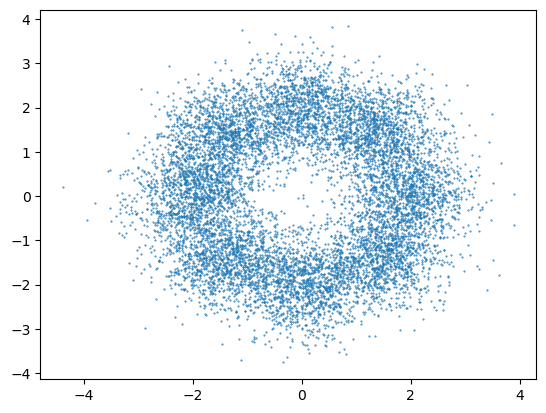

In [ ]:
dat = ToysDataset(10000)
plt.scatter(dat.source[:,0], dat.source[:,1], s=0.2)
plt.show()


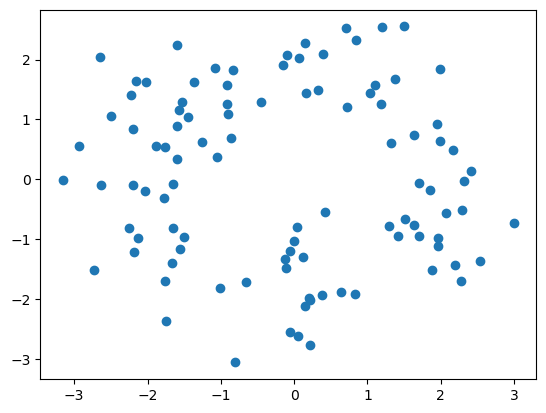

In [ ]:
# scatter plot
plt.scatter(dat.source[:,0], dat.source[:,1])
plt.show()
